In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
import xarray as xr
import geopandas as gpd
import regionmask

In [2]:
file = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\all codes\TA_PA_DL_no-prot_somalia_dummies.csv"
df = pd.read_csv(file)

In [23]:
file = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\drought\pdsisc.monthly.maps.1850-2018.fawc-1.r2.5x2.5.ipe-2.nc"

with xr.open_dataset(file, decode_times=False) as file_nc:
    drought_xr = file_nc

drought_xr

<xarray.Dataset>
Dimensions:     (lat: 55, lon: 144, time: 2028)
Coordinates:
  * lat         (lat) float32 -58.75 -56.25 -53.75 -51.25 ... 71.25 73.75 76.25
  * lon         (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time        (time) float32 1.85e+03 1.85e+03 ... 2.019e+03 2.019e+03
Data variables:
    sc_PDSI_pm  (time, lat, lon) float32 ...
Attributes:
    creation_time:  Fri Mar 29 13:58:09 EDT 2019
    Conventions:    NCAR
    source_file:    tmp2/DaiP_4.02/pdsisc.monthly.maps.1850-2018.fawc=1.r2.5x...
    description:    \nMonthly Self-calibrated Palmer Drought Severity Index (...
    history:        Fri Apr 16 09:58:15 2021: ncatted -a units,lat,c,c,degree...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....

In [26]:
path = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\som_adm_ocha_itos_20230308_shp\som_admbnda_adm1_ocha_20230308.shp"
states_gdf = gpd.read_file(path) 

In [27]:
def get_aoi(shp, world=True):
    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

bounds = get_aoi(states_gdf)

In [30]:
start_date = '1901-01-16'
end_date = '2022-12-16'

region = drought_xr['sc_PDSI_pm'].sel(
    #time=slice(start_date, end_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

In [32]:
region_mask = regionmask.mask_3D_geopandas(states_gdf,
                                         drought_xr.lon,
                                         drought_xr.lat)

somalia = region.where(region_mask).groupby("time").mean(["lat", "lon"]).to_dataframe().reset_index()

In [ ]:
replacement_dict = {0  :  'Awdal',
1    :         'Bakool',
2      :       'Banadir',
3      :         'Bari',
4       :         'Bay',
5        :  'Galgaduud',
6          :      'Gedo',
7          :   'Hiraan',
8   :       'Lower Juba',
9   :   'Lower Shabelle',
10  :      'Middle Juba',
11   : 'Middle Shabelle',
12    :          'Mudug',
13    :        'Nugaal',
14      :       'Sanaag',
15       :        'Sool',
16        :   'Togdheer',
17   : 'Woqooyi Galbeed'}

somalia['region'] = somalia['region'].replace(replacement_dict)

In [36]:
# merge states_gdf with summary1 based on column 'region'
merged = states_gdf.merge(somalia, left_on='ADM1_EN', right_on='region')

In [37]:
# Slice the data
start_date = '1998.125'
end_date = '1998.125'

one_month_region = drought_xr["sc_PDSI_pm"].sel(
    time=slice(start_date, end_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

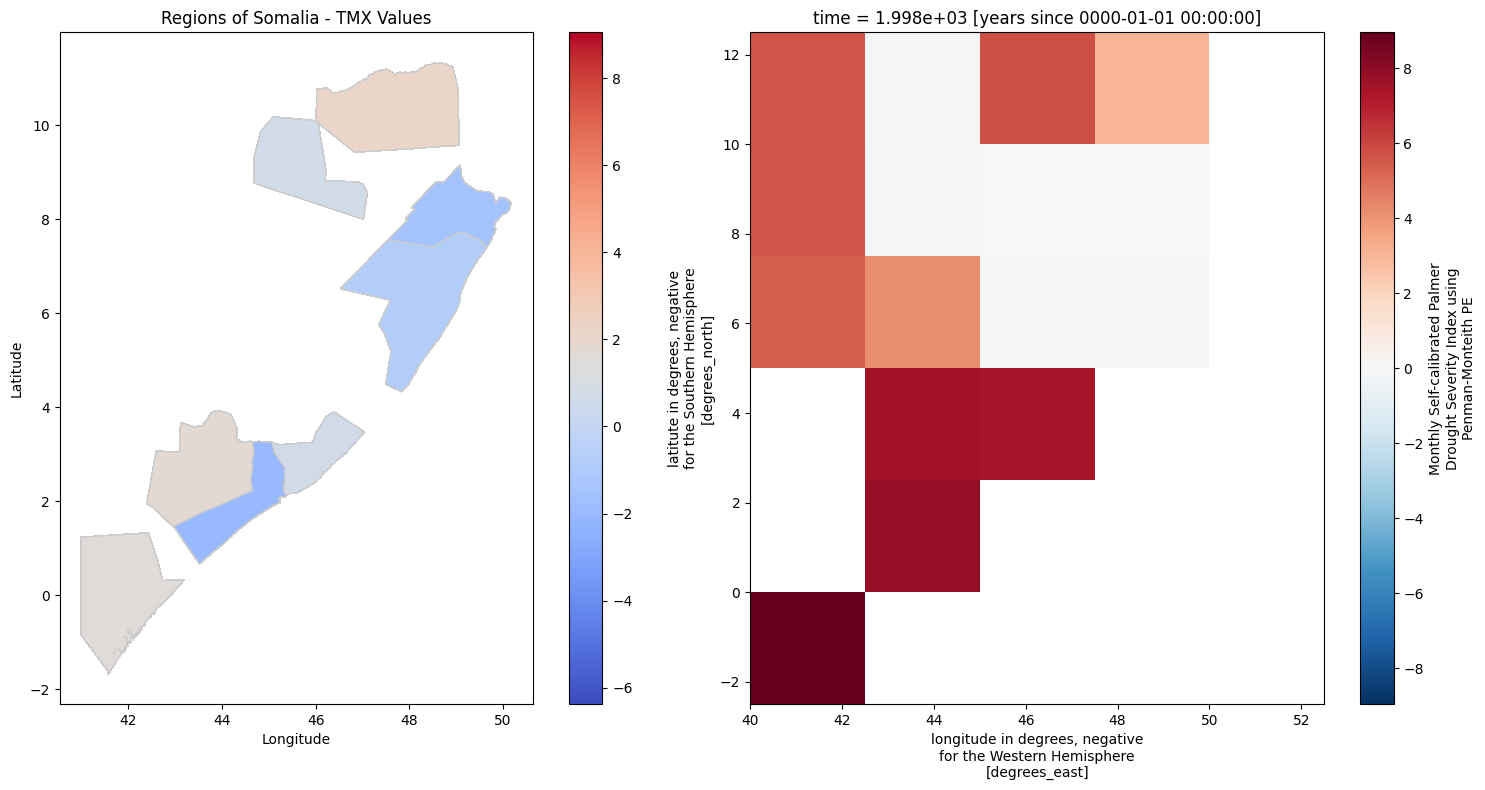

In [38]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first map - Regions of Somalia colored by tmx
merged.plot(column='sc_PDSI_pm', cmap='coolwarm', linewidth=0.8, ax=ax1, edgecolor='0.8', legend=True)
ax1.set_title('Regions of Somalia - TMX Values')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Plot the second map - two_months_region
one_month_region.plot(ax=ax2)

# Display the plot
plt.tight_layout()
plt.show()

In [35]:
#check how many elements in somalia['sc_PDSI_pm'] are not nan
somalia['sc_PDSI_pm'].notnull().sum()

8908